In [ ]:
# Copyright 2022 Intrinsic Innovation LLC.
# Copyright 2024 DeepMind Technologies Limited.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This second tutorial is more detailed than the [first one](https://colab.research.google.com/github/deepmind/PGMax/blob/master/examples/ising_model.ipynb). In particular, we consider a richer PGM with two types of factors, we discuss adding factors individually vs. as a group, and we show how to run inference in parallel in PGMax using `jax.vmap`.

We consider a [Restricted Boltzmann Machine (RBM)](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine), a well-known and widely used PGM for learning probabilistic distributions over binary data.

An RBM with 5 hidden variables and 4 visible variables look as follows:

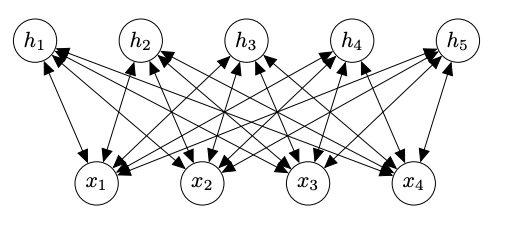

We demonstrate how we can easily implement [perturb-and-max-product (PMP)](https://proceedings.neurips.cc/paper/2021/hash/07b1c04a30f798b5506c1ec5acfb9031-Abstract.html) sampling from an RBM trained on MNIST digits using PGMax.

PMP is a recently proposed method for approximately sampling from a PGM by computing the maximum-a-posteriori (MAP) configuration (using max-product LBP) of a perturbed version of the model. Note that we also use PMP in the [first tutorial](https://colab.research.google.com/github/deepmind/PGMax/blob/master/examples/ising_model.ipynb) to sample from an Ising model.

We start by making some necessary imports.

In [ ]:
# # Uncomment this block if running on colab.research.google.com
# !pip install git+https://github.com/deepmind/PGMax.git
# !wget https://raw.githubusercontent.com/deepmind/PGMax/main/examples/example_data/rbm_mnist.npz
# !mkdir example_data
# !mv rbm_mnist.npz  example_data/

In [ ]:
%matplotlib inline
import functools

import jax
import matplotlib.pyplot as plt
import numpy as np

############
# Load PGMax
from pgmax import fgraph, fgroup, infer, vgroup

Next, we load the RBM trained in Sec. 5.5 of the [PMP paper](https://proceedings.neurips.cc/paper/2021/hash/07b1c04a30f798b5506c1ec5acfb9031-Abstract.html) which has been trained on MNIST digits.

In [ ]:
# Load data
folder_name = "example_data/"
params = np.load(open(folder_name + "rbm_mnist.npz", 'rb'), allow_pickle=True)
bv = params["bv"]
bh = params["bh"]
W = params["W"]

We now build the RBM factor graph using PGMax.

As before, we use [`NDVarArray`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.vgroup.NDVarArray) to create the variables groups, and we initialize the [`FactorGraph`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.fgraph.FactorGraph) `fg` with the set of defined [`VarGroup`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.vgroup.VarGroup)s.

In [ ]:
# Initialize factor graph
hidden_variables = vgroup.NDVarArray(num_states=2, shape=bh.shape)
visible_variables = vgroup.NDVarArray(num_states=2, shape=bv.shape)
fg = fgraph.FactorGraph(variable_groups=[hidden_variables, visible_variables])

We create the unary and pairwise factors of the RBM with the [`EnumFactorGroup`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.fgroup.EnumFactorGroup) and [`PairwiseFactorGroup`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.fgroup.PairwiseFactorGroup) classes, then add them to `fg`.

In [ ]:
# Create unary factors
hidden_unaries = fgroup.EnumFactorGroup(
    variables_for_factors=[[hidden_variables[ii]] for ii in range(bh.shape[0])],
    factor_configs=np.arange(2)[:, None],
    log_potentials=np.stack([np.zeros_like(bh), bh], axis=1),
)
visible_unaries = fgroup.EnumFactorGroup(
    variables_for_factors=[[visible_variables[jj]] for jj in range(bv.shape[0])],
    factor_configs=np.arange(2)[:, None],
    log_potentials=np.stack([np.zeros_like(bv), bv], axis=1),
)

# Create pairwise factors
log_potential_matrix = np.zeros(W.shape + (2, 2)).reshape((-1, 2, 2))
log_potential_matrix[:, 1, 1] = W.ravel()

variables_for_factors = [
    [hidden_variables[ii], visible_variables[jj]]
    for ii in range(bh.shape[0])
    for jj in range(bv.shape[0])
]
pairwise_factors = fgroup.PairwiseFactorGroup(
    variables_for_factors=variables_for_factors,
    log_potential_matrix=log_potential_matrix,
)

# Add factors to the FactorGraph
fg.add_factors([hidden_unaries, visible_unaries, pairwise_factors])

#### *Note to the reader*

An alternative way displayed below adds the above [`Factor`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.factor.Factor)s iteratively without building the FactorGroup. This approach is not recommended as it can be much slower than using [`FactorGroup`](https://pgmax.readthedocs.io/en/latest/_autosummary/pgmax.fgroup.fgroup.FactorGroup.html#pgmax.fgroup.fgroup.FactorGroup)s.

~~~python
from pgmax import factor
import itertools
from tqdm import tqdm

# Add unary factors
for ii in range(bh.shape[0]):
  unary_factor = factor.EnumFactor(
      variables=[hidden_variables[ii]],
      factor_configs=np.arange(2)[:, None],
      log_potentials=np.array([0, bh[ii]]),
  )
  fg.add_factors(unary_factor)

for jj in range(bv.shape[0]):
  unary_factor = factor.EnumFactor(
      variables=[visible_variables[jj]],
      factor_configs=np.arange(2)[:, None],
      log_potentials=np.array([0, bv[jj]]),
  )
  fg.add_factors(unary_factor)

# Add pairwise factors
factor_configs = np.array(list(itertools.product(np.arange(2), repeat=2)))
for ii in tqdm(range(bh.shape[0])):
  for jj in range(bv.shape[0]):
    pairwise_factor = factor.EnumFactor(
        variables=[hidden_variables[ii], visible_variables[jj]],
        factor_configs=factor_configs,
        log_potentials=np.array([0, 0, 0, W[ii, jj]]),
    )
    fg.add_factors(pairwise_factor)
~~~

Once we have added the factors, we can run max-product LBP and get the MAP decoding by
~~~python
bp = infer.build_inferer(fg.bp_state, backend="bp")
bp_arrays = bp.run(bp.init(), num_iters=100, damping=0.5, temperature=0.0)
beliefs = bp.get_beliefs(bp_arrays)
map_states = infer.decode_map_states(beliefs)
~~~
or run sum-product LBP and get the estimated marginals by
~~~python
bp = infer.build_inferer(fg.bp_state, backend="bp")
bp_arrays = bp.run(bp.init(), num_iters=100, damping=0.5, temperature=1.0)
beliefs = bp.get_beliefs(bp_arrays)
marginals = infer.get_marginals(beliefs)
~~~
More generally, PGMax implements LBP for any temperature, with `temperature=0.0` and `temperature=1.0` corresponding to the commonly used max/sum-product LBP respectively.

We are no ready to demonstrate PMP sampling from RBM. PMP perturbs the model with Gumbel unary potentials. The RBM samples are the MAP decodings from running max-product LBP on the perturbed model.

In [ ]:
bp = infer.build_inferer(fg.bp_state, backend="bp")

In [ ]:
bp_arrays = bp.init(
    evidence_updates={
        hidden_variables: np.random.gumbel(size=(bh.shape[0], 2)),
        visible_variables: np.random.gumbel(size=(bv.shape[0], 2)),
    }
)
bp_arrays, msgs_deltas = bp.run_with_diffs(
    bp_arrays, num_iters=500, damping=0.5, temperature=0.0
)
beliefs = bp.get_beliefs(bp_arrays)

Visualizing the MAP decoding, we see that we have sampled an MNIST digit!

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
map_states = infer.decode_map_states(beliefs)
ax.imshow(
    map_states[visible_variables].copy().reshape((28, 28)),
    cmap="gray",
)
ax.axis("off")

We use `bp.run_with_diffs` to monitor the (unguaranteed) convergence of BP

If we do not want to access `msgs_deltas` we can also call

`bp_arrays = bp.run(bp_arrays, num_iters=500, damping=0.5, temperature=0.0)`

In [ ]:
print(msgs_deltas[-10:])

plt.figure(figsize=(8, 5))
plt.plot(msgs_deltas)
plt.title("Max-product convergence", fontsize=18)
plt.xlabel("BP iteration", fontsize=16)
plt.ylabel("Max abs msgs diff", fontsize=16)

PGMax can compute the energy of a decoding, expressed by its MAP states.

`debug_mode` gives access to the individual contribution of each variable and factor to the energy.

~~~python
decoding_energy, vars_energies, factors_energies = infer.compute_energy(
    fg.bp_state, bp_arrays, map_states, debug_mode=True
)
~~~

In [ ]:
decoding_energy = infer.compute_energy(fg.bp_state, bp_arrays, map_states)[0]
print("The energy of the decoding is", decoding_energy)

The arguments of `bp` are several useful functions to run LBP. In particular, `bp.init`, `bp.run`, `bp.get_beliefs` are pure functions with no side-effects. This design choice means that we can easily apply JAX transformations like `jit`/`vmap`/`grad`, etc., to these functions, and additionally allows PGMax to seamlessly interact with other packages in the rapidly growing JAX ecosystem (see [here](https://deepmind.com/blog/article/using-jax-to-accelerate-our-research) and [here](https://github.com/n2cholas/awesome-jax)).

For instance, we can sample a batch of digits in parallel as follows:

In [ ]:
# Run inference in parallel
n_samples = 10
bp_arrays = jax.vmap(bp.init, in_axes=0, out_axes=0)(
    evidence_updates={
        hidden_variables: np.random.gumbel(size=(n_samples, bh.shape[0], 2)),
        visible_variables: np.random.gumbel(size=(n_samples, bv.shape[0], 2)),
    },
)
bp_arrays = jax.vmap(
    functools.partial(bp.run, num_iters=100, damping=0.5, temperature=0.0),
    in_axes=0,
    out_axes=0,
)(bp_arrays)

beliefs = jax.vmap(bp.get_beliefs, in_axes=0, out_axes=0)(bp_arrays)
map_states = infer.decode_map_states(beliefs)

In [ ]:
# Visualize the decodings
fig, ax = plt.subplots(2, 5, figsize=(16, 6))
for ii in range(10):
    ax[np.unravel_index(ii, (2, 5))].imshow(
        map_states[visible_variables][ii].copy().reshape((28, 28)), cmap="gray"
    )
    ax[np.unravel_index(ii, (2, 5))].axis("off")

fig.tight_layout()